# Bluesky interfacing demo

This Jupyter Notebook demonstrates the use of Bluesky as a Python package and how it can be used to generate aircraft trajectories.

**Note:** Make sure that you have Bluesky installed as a package in your Python environment.

Let's start by importing the relevant modules.

In [1]:
import numpy as np

import bluesky as bs
from bluesky import traffic as tr
from bluesky import settings
from bluesky.traffic.route import Route
from bluesky.navdatabase import Navdatabase
from bluesky.simulation import Simulation
from bluesky.traffic.performance.perfbase import PerfBase

Using Python-based geo functions
Failed to load BADA performance model


We create a dummy class that acts as the screen of BlueSky. Since we don't want to actually load the screen from BlueSky here, a simple and small class is used instead to avoid errors when something within BlueSky is calling the *echo* function.

In [2]:
class ScreenDummy:
    """
    Dummy class for the screen.
    
    To avoid having to start the BlueSky screen, a simple dummy is used here to
    handle "echo" commands from within BlueSky. These could be logged in this
    class if needed.
    """

    def __init__(self):
        pass

    def echo(self, text='', flags=0):
        """Dummy to receive echos from other parts of BlueSky"""
        pass

Once the modules are imported and we have a screen, we have to initialize the settings and create the Traffic, Navdatabase and Simulation objects. These are singletons and, thus, exist only once. We assign these to the bluesky module (here imported as *bs*).

In [3]:
# initialize global settings
settings.init('')

# manually set the performance model to the one defined in the settings before
# creating the Traffic object
PerfBase.setdefault(settings.performance_model)

# initialize dummy screen
bs.scr = ScreenDummy()

# manually create singletons
traf = tr.Traffic()
bs.traf = traf

navdb = Navdatabase()
bs.navdb = navdb

sim = Simulation()
bs.sim = sim


No config file settings.cfg found in your BlueSky starting directory!

This config file contains several default settings related to the simulation loop and the graphics.
A default version will be generated, which you can change if necessary before the next time you run BlueSky.

Creating directory "output"
Creating directory "data/cache\py3"
Creating directory "data/performance/BADA", and copying default files
Creating directory "scenario", and copying default files
Creating directory "plugins", and copying default files
Loading global navigation database...
Cachefile not found: data/cache\py3\navdata.p
Reading nav.dat
Reading fix.dat
Reading awy.dat
Reading apt.dat from apt.zip
Writing cache: data/cache\py3\navdata.p


Now that everything is initialized, we can get started and and generate some traffic. Here, we generate 3 aircraft of the type *A320*.

In [4]:
# generate some trajectories
n = 3

# aircraft IDs (called "000", "001", ...)
acids = [str(i).zfill(3) for i in range(n)]

# aircraft type
actypes = ["A320"] * n

# create traffic
traf.cre(acid=acids, actype=actypes)

# alternative: initialize the traffic in flight by passing the initial position,
#              heading, altitude, and speed.
# traf.cre(acid=acids, actype=actypes, aclat=aclats, aclon=aclons,
#         achdg=achdgs, acalt=acalts, acspd=acspds)

The traffic in this example are not given any initial conditions such as initial position and velocity. This is not needed when the traffic departs at an airport. You can also pass the initial conditions as additional parameters to the funciton if you want to initialize the traffic in flight.

Next we want to assign some waypoints to the traffic. In this example we assign the same route to all the flights. This is just for the sake of simplicity and it obviously wouldn't make a lot of sense in a practical application, but it should highlight how waypoints are added.

In [5]:
# iterate over traffic and add the same waypoints
for acid in acids:
    idx = bs.traf.id.index(acid)

    # set the origin (not needed if initialized in flight)
    traf.ap.setorig(idx, 'EGLL')

    # add some waypoints, here only the altitude (in m) is passed to the 
    # function, but you can additionally pass a speed as well
    Route._routes.get(acid).addwptStack(idx, 'BPK', 1828.8)
    Route._routes.get(acid).addwptStack(idx, 'TOTRI', 3261.36)
    Route._routes.get(acid).addwptStack(idx, 'MATCH', 3505.2)
    Route._routes.get(acid).addwptStack(idx, 'BRAIN', 4998.72)

    # you can also set the way the waypoint should be flown
    # Route._routes.get(acid).addwptMode(idx, 'FLYOVER')

    # you can also set a destination
    # traf.ap.setdest(idx, 'EHAM')

    # turn on VNAV
    traf.ap.setVNAV(idx, True)

# turn off traffic resolution for all flights
traf.cr.setresooff(range(n))

True

Now that all our traffic has a route to fly, it's time to start the simulation.

In [6]:
# simulation time step
bs.sim.simdt = 1

# initial simulation time
bs.sim.simt = 0

# we'll run the simulation for up to 4000 seconds
t_max = 4000

ntraf = traf.ntraf
n_steps = t_max//bs.sim.simdt+1
t = np.linspace(0, t_max, n_steps)

# allocate some empty arrays for the results
res = np.zeros((n_steps, 4, ntraf))

# iteratively simulate the traffic
for i in range(n_steps):

    # save the results from the simulator in the results array,
    # here we keep the latitude, longitude, altitude and TAS
    res[i] = [bs.traf.lat,
                bs.traf.lon,
                bs.traf.alt,
                bs.traf.tas]

    # increment simulation time
    bs.sim.simt += bs.sim.simdt

    # let bluesky do one simulation step
    traf.update()

Finally, we do a bit of plotting to visualize the results. Again, the three trajectories are the same since we passed the same route to them, but this, of course, can be easily changed.

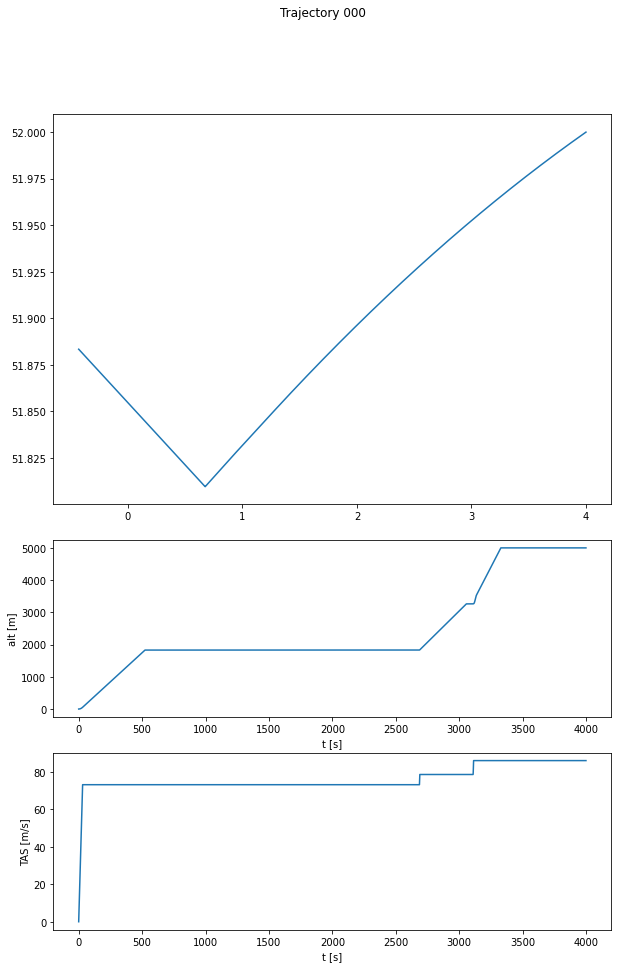

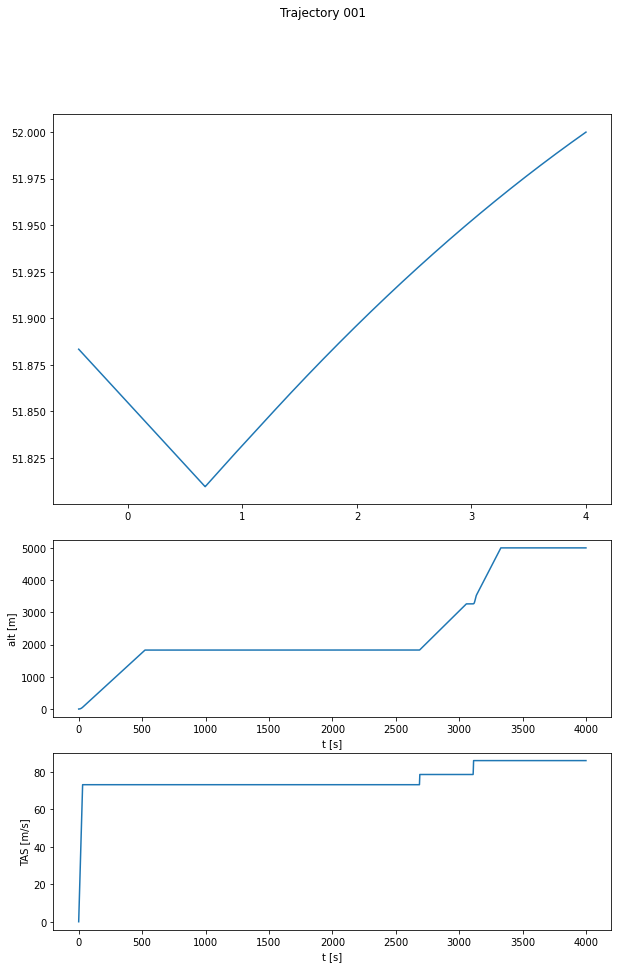

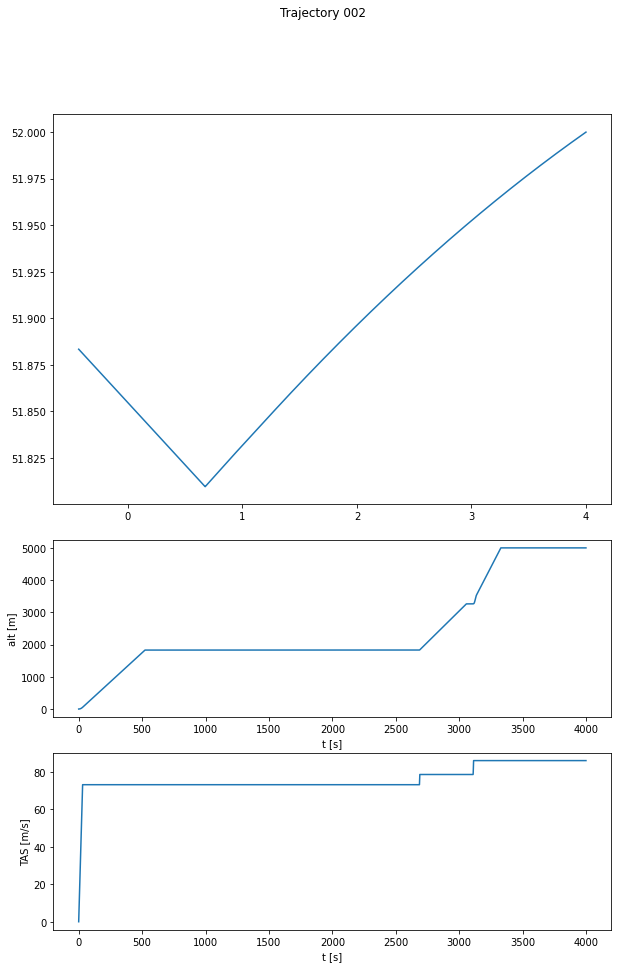

In [7]:
# plot
import matplotlib.pyplot as plt

for idx in range(len(acids)):
    fig = plt.figure(figsize=(10, 15))
    ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((4, 1), (2, 0))
    ax3 = plt.subplot2grid((4, 1), (3, 0))

    ax1.plot(res[:, 1, idx], res[:, 0, idx])

    ax2.plot(t, res[:, 2, idx])
    ax2.set_xlabel('t [s]')
    ax2.set_ylabel('alt [m]')

    ax3.plot(t, res[:, 3, idx])
    ax3.set_xlabel('t [s]')
    ax3.set_ylabel('TAS [m/s]')
    
    fig.suptitle('Trajectory {}'.format(acids[idx]))
